# Accuracy Evaluation

### Evaluation of the accuracy and the influence of parameters and input caracteristics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import polyfit

from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
plt.rcParams['xtick.major.pad']='0'

In [3]:
# Set up methods' colors
methods_colors = {
    "oracle": "#FFFFFF",
    "avg_ens": "#FF7133",
    "best_ms": "#33D4FF",
    "detectors": "#CCCCCC",
    "feature_based": "#91AAC2",
    "sit": "#FFB522",
    "conv": "#4494FF",
    "conv_2": "#0048FF",
    "rocket": "#EA7DFF",
    "best_ad_train": "#228B22",
    "worst_ad_test": "#8B0000",
}

# Get results data

Please select a measure for the analysis. You can choose between VUS_PR and AUC_PR. This file contains the accuracy scores for 496 time series (time series in the test set that where not used for training the model selection methods).

**Make sure to change to the name of the file that you want to read from**

In [44]:
# Replace this value with "AUC_PR" or "VUS_PR" to obtain the corresponding results
measure_name = 'AUC_PR'

# ['INTERPRETABILITY_HIT_2_SCORE', 'INTERPRETABILITY_LOG_SCORE']

# Uncomment this command and all plt.savefig(...) commands to save the generated figures
# figure_path = 'dummy/path/{}.svg'

df = pd.read_csv('../../results_mts/accuracy/settings_one/current_accuracy_{}.csv'.format(measure_name))
if 'Unnamed: 0' in df.columns:
    df = df.drop(labels='Unnamed: 0', axis=1)

methods_conv = [
    'inception_time_{}',
    'convnet_{}',
    'resnet_{}',]

methods_sit = [
    'sit_conv_{}',
    'sit_linear_{}',
    'sit_stem_{}',
    'sit_stem_relu_{}',]

methods_ts = ['rocket_{}']

methods_feature = [
    'ada_boost_{}',
    'knn_{}',
    'decision_tree_{}',
    'random_forest_{}',
    'mlp_{}',
    'bayes_{}',
    'qda_{}',
    'svc_linear_{}']

# old_methods = ['IFOREST', 'LOF', 'MP', 'NORMA', 'IFOREST1', 'HBOS', 'OCSVM','PCA', 'AE', 'CNN', 'LSTM', 'POLY']

old_methods = ['CBLOF', 'COF', 'COPOD', 'HBOS', 'LOF', 'PCC', 'AutoEncoder (AE)', 'DenoisingAutoEncoder (DAE)']

Base_methods = ['Avg Ens','Oracle']

# all_length = [16, 32, 64, 128, 256, 512, 768, 1024]
all_length = [32]

all_methods_ens = [meth.format(length) for meth in methods_conv for length in all_length]
all_methods_ens += [meth.format(length) for meth in methods_sit for length in all_length]
all_methods_ens += [meth.format(length) for meth in methods_ts for length in all_length]
all_methods_ens += [meth.format(length) for meth in methods_feature for length in all_length]

# Keep only the methods that exist in the results you read
all_methods = old_methods + Base_methods + all_methods_ens
all_methods = [x for x in all_methods if x in df.columns]

# Create a list of all different classes of methods
split = [x.rsplit('_', 1)[0] for x in all_methods]
used = set()
all_methods_class = [x for x in split if x not in used and (used.add(x) or True)]

df

,dataset,filename,label,ada_boost_32,ada_boost_32_class,bayes_32,bayes_32_class,convnet_32,convnet_32_class,decision_tree_32,...,Oracle,Avg Ens,CBLOF,COF,COPOD,HBOS,LOF,PCC,AutoEncoder (AE),DenoisingAutoEncoder (DAE)
0,settings_one,synthetic_batch_0.out,AutoEncoder (AE),0.757202,PCC,0.854462,DenoisingAutoEncoder (DAE),0.854462,DenoisingAutoEncoder (DAE),0.757202,...,0.870892,0.860284,0.594641,0.621662,0.764133,0.810416,0.636436,0.757202,0.870892,0.854462
1,settings_one,synthetic_batch_103.out,PCC,0.708190,PCC,0.708190,PCC,0.697205,DenoisingAutoEncoder (DAE),0.708190,...,0.708190,0.725861,0.561347,0.541356,0.646938,0.677935,0.554501,0.708190,0.678596,0.697205
2,settings_one,synthetic_batch_104.out,PCC,0.690434,PCC,0.690434,PCC,0.566003,DenoisingAutoEncoder (DAE),0.690434,...,0.690434,0.661742,0.447789,0.458915,0.514776,0.674933,0.499221,0.690434,0.639868,0.566003
3,settings_one,synthetic_batch_105.out,DenoisingAutoEncoder (DAE),0.588703,PCC,0.722711,DenoisingAutoEncoder (DAE),0.722711,DenoisingAutoEncoder (DAE),0.588703,...,0.722711,0.655064,0.525162,0.588808,0.476079,0.675293,0.607942,0.588703,0.714586,0.722711
4,settings_one,synthetic_batch_108.out,COPOD,0.717357,PCC,0.717357,PCC,0.620245,DenoisingAutoEncoder (DAE),0.717357,...,0.766179,0.742165,0.553215,0.503375,0.766179,0.709184,0.569490,0.717357,0.539746,0.620245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,settings_one,synthetic_batch_84.out,COPOD,0.764020,PCC,0.764020,PCC,0.722397,DenoisingAutoEncoder (DAE),0.764020,...,0.813637,0.803357,0.686482,0.570312,0.813637,0.743838,0.625487,0.764020,0.614032,0.722397
81,settings_one,synthetic_batch_96.out,DenoisingAutoEncoder (DAE),0.735333,PCC,0.735333,PCC,0.830275,DenoisingAutoEncoder (DAE),0.735333,...,0.830275,0.813798,0.613932,0.611811,0.740034,0.816265,0.646492,0.735333,0.765829,0.830275
82,settings_one,synthetic_batch_97.out,PCC,0.726470,PCC,0.726470,PCC,0.686078,DenoisingAutoEncoder (DAE),0.726470,...,0.726470,0.748789,0.588203,0.467954,0.586714,0.710754,0.518723,0.726470,0.725997,0.686078
83,settings_one,synthetic_batch_98.out,DenoisingAutoEncoder (DAE),0.478641,PCC,0.478641,PCC,0.481149,DenoisingAutoEncoder (DAE),0.478641,...,0.481149,0.510808,0.371278,0.428148,0.390388,0.471858,0.461353,0.478641,0.441739,0.481149


### Define camera-ready method names

In [45]:
# all_length = [16, 32, 64, 128, 256, 512, 768, 1024]
all_length = [32]

template_names = {
    'inception_time_{}': 'InceptTime-{}',
    'convnet_{}': 'ConvNet-{}',
    'resnet_{}': 'ResNet-{}',
    'sit_conv_{}': 'SiT-conv-{}',
    'sit_linear_{}': 'SiT-linear-{}',
    'sit_stem_{}': 'SiT-stem-{}',
    'sit_stem_relu_{}': 'SiT-stem-ReLU-{}',
    'rocket_{}': 'Rocket-{}',
    'ada_boost_{}': 'AdaBoost-{}',
    'knn_{}': 'kNN-{}',
    'decision_tree_{}': 'DecisionTree-{}',
    'random_forest_{}': 'RandomForest-{}',
    'mlp_{}': 'MLP-{}',
    'bayes_{}': 'Bayes-{}',
    'qda_{}': 'QDA-{}',
    'svc_linear_{}': 'SVC-{}',
    'IFOREST': 'IForest',
    'LOF': 'LOF',
    'MP': 'MP',
    'NORMA': 'NormA',
    'IFOREST1': 'IForest1',
    
    'CBLOF': 'CBLOF',
    'COF': 'COF',
    'COPOD': 'COPOD',
    'PCC': 'PCC',
    'HBOS': 'HBOS',
    'OCSVM': 'OCSVM',
    'PCA': 'PCA',
    # 'AE': 'AE',
    'AutoEncoder (AE)': 'AE',
    'DenoisingAutoEncoder (DAE)': 'DAE',
    'CNN': 'CNN',
    'LSTM': 'LSTM',
    'POLY': 'POLY',
    'Avg Ens': 'Avg Ens',
    'Oracle': 'Oracle',
    'VUS_PR': 'VUS-PR',
    'label': 'Label',
    'best_ms': 'Best MS',
    'convnet': 'ConvNet',
    'resnet': 'ResNet',
    'rocket': 'Rocket',
    'knn': 'kNN',
    'sit_stem': 'SiT-stem',
    'sit': 'SiT',
    'feature_based': 'Feature-based',
    'AUC_PR': 'AUC-PR',
    'AUC_ROC': 'AUC-ROC',
    'VUS_ROC': 'VUS_ROC',
    'INTERPRETABILITY_LOG_SCORE':'INTERPRETABILITY_LOG_SCORE',
    'INTERPRETABILITY_HIT_2_SCORE': 'INTERPRETABILITY_HIT_2_SCORE'
}

final_names = {}
for length in all_length:
    for key, value in template_names.items():
        if '{}' in key:
            new_key = key.format(length)
            new_value = value.format(length)
            final_names[new_key] = new_value
        else:
            final_names[key] = value
print(final_names)

{'inception_time_32': 'InceptTime-32', 'convnet_32': 'ConvNet-32', 'resnet_32': 'ResNet-32', 'sit_conv_32': 'SiT-conv-32', 'sit_linear_32': 'SiT-linear-32', 'sit_stem_32': 'SiT-stem-32', 'sit_stem_relu_32': 'SiT-stem-ReLU-32', 'rocket_32': 'Rocket-32', 'ada_boost_32': 'AdaBoost-32', 'knn_32': 'kNN-32', 'decision_tree_32': 'DecisionTree-32', 'random_forest_32': 'RandomForest-32', 'mlp_32': 'MLP-32', 'bayes_32': 'Bayes-32', 'qda_32': 'QDA-32', 'svc_linear_32': 'SVC-32', 'IFOREST': 'IForest', 'LOF': 'LOF', 'MP': 'MP', 'NORMA': 'NormA', 'IFOREST1': 'IForest1', 'CBLOF': 'CBLOF', 'COF': 'COF', 'COPOD': 'COPOD', 'PCC': 'PCC', 'HBOS': 'HBOS', 'OCSVM': 'OCSVM', 'PCA': 'PCA', 'AutoEncoder (AE)': 'AE', 'DenoisingAutoEncoder (DAE)': 'DAE', 'CNN': 'CNN', 'LSTM': 'LSTM', 'POLY': 'POLY', 'Avg Ens': 'Avg Ens', 'Oracle': 'Oracle', 'VUS_PR': 'VUS-PR', 'label': 'Label', 'best_ms': 'Best MS', 'convnet': 'ConvNet', 'resnet': 'ResNet', 'rocket': 'Rocket', 'knn': 'kNN', 'sit_stem': 'SiT-stem', 'sit': 'SiT', 

# Overview of the experimental analysis

In this section, we compare the existing detectors with the Averaging Ensemble, the Oracle, and one of the best model selection methods from our experimental evaluation.

Best Model Selector (MS) is: Bayes-32


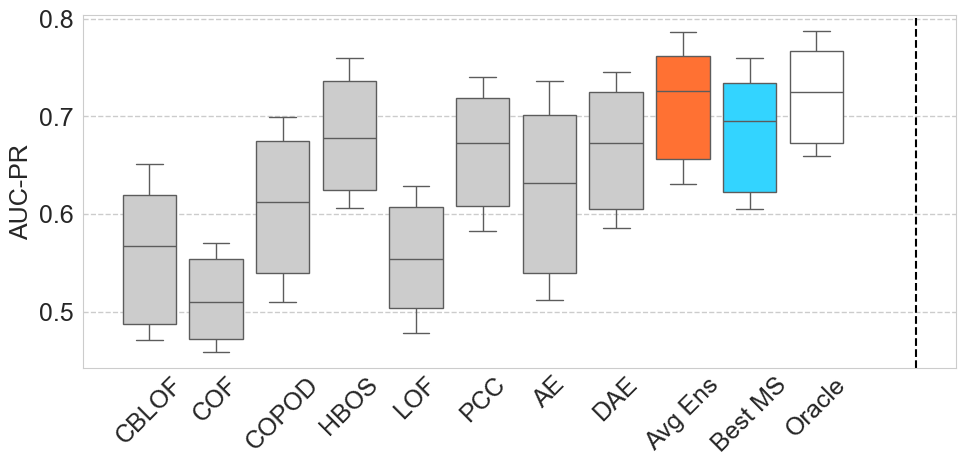

In [46]:
def plot_result_boxplot_dataset():
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(10, 5))
    plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.2)
    
    # Calculate the mean performance for each Model Selector (MS)
    method_means = df[[x for x in all_methods_ens if x in df.columns]].mean()
    best_ms = method_means.idxmax() # Best MS may differ since results are may slightly vary (although distributions are solid)
#     best_ms = 'resnet_1024' # Best model selector at the time publishing of our paper 
    print(f"Best Model Selector (MS) is: {final_names[best_ms]}")
    
    # old_method_order = ['OCSVM','POLY','LSTM','CNN','HBOS','PCA','IFOREST','AE','LOF','IFOREST1','MP','NORMA']
    old_method_order = ['CBLOF','COF','COPOD','HBOS','LOF','PCC','AutoEncoder (AE)','DenoisingAutoEncoder (DAE)']
    my_pal = {method: methods_colors["detectors"] for method in old_method_order}
    my_pal = {**my_pal, **{"Avg Ens": methods_colors["avg_ens"], best_ms: methods_colors["best_ms"], 'Oracle': methods_colors["oracle"] }}
    
    tmp_methods = old_method_order + ['Avg Ens', best_ms, 'Oracle']
    bplot = sns.boxplot(data=df[tmp_methods], palette=my_pal, showfliers = False, saturation=1, whis=0.241289844)
    
    xticks_labels = []
    for x in tmp_methods:
        if x != best_ms:
            xticks_labels.append(final_names[x])
        else:
            xticks_labels.append(final_names['best_ms'])
    
    plt.xticks(list(range(len(xticks_labels))), xticks_labels, rotation=45)
    plt.ylabel(final_names[measure_name])

    plt.axvline(11.5, color='black', linestyle='--')
    plt.tight_layout()
#     plt.savefig(figure_path.format('1_intro_fig_1'), transparent=True)
    plt.show()
    plt.close()
    
plot_result_boxplot_dataset()

# Overall results of the experimental analysis

We first analyze the accuracy of all
model selection methods (using all window lengths) and compare
them to the Oracle (perfect classifier), the Averaging ensembling
method (i.e., running all anomaly detection methods and returns
and average all anomaly scores), and anomaly detection methods
in the TSB-UAD benchmark.

The figure below depicts the overall measure chosen at the beginning, over the entire TSB-UAD benchmark (i.e., each box-plot
corresponds to 496 accuracy values for the 496 time series into
the test set). The Convoutional-based approaches are in blue, the
Transformer-based approaches are in red, the Feature-based approaches are in green, Rocket models are in dark grey, and the
anomaly detection methods of the TSB-UAD benchmark are in
light blue. The oracle is the top box plot (in white), and the Averaging ensembling is the dark red box plot. The box-plot are sorted
based on the median value. In total, we compare 142 models on 496
time series.

First, we observe that almost all model selection methods outperform the existing anomaly detection methods regardless of the
accuracy measure used. We also see that most model selection
methods outperform the Averaging ensembling approach. Thus,
we can conclude that model selection using time series classifiers
significantly improves the state of the art for anomaly detection in
time series.

/tmp/ipykernel_185413/3174893258.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.axes.set_xticklabels(new_xticks_labels)


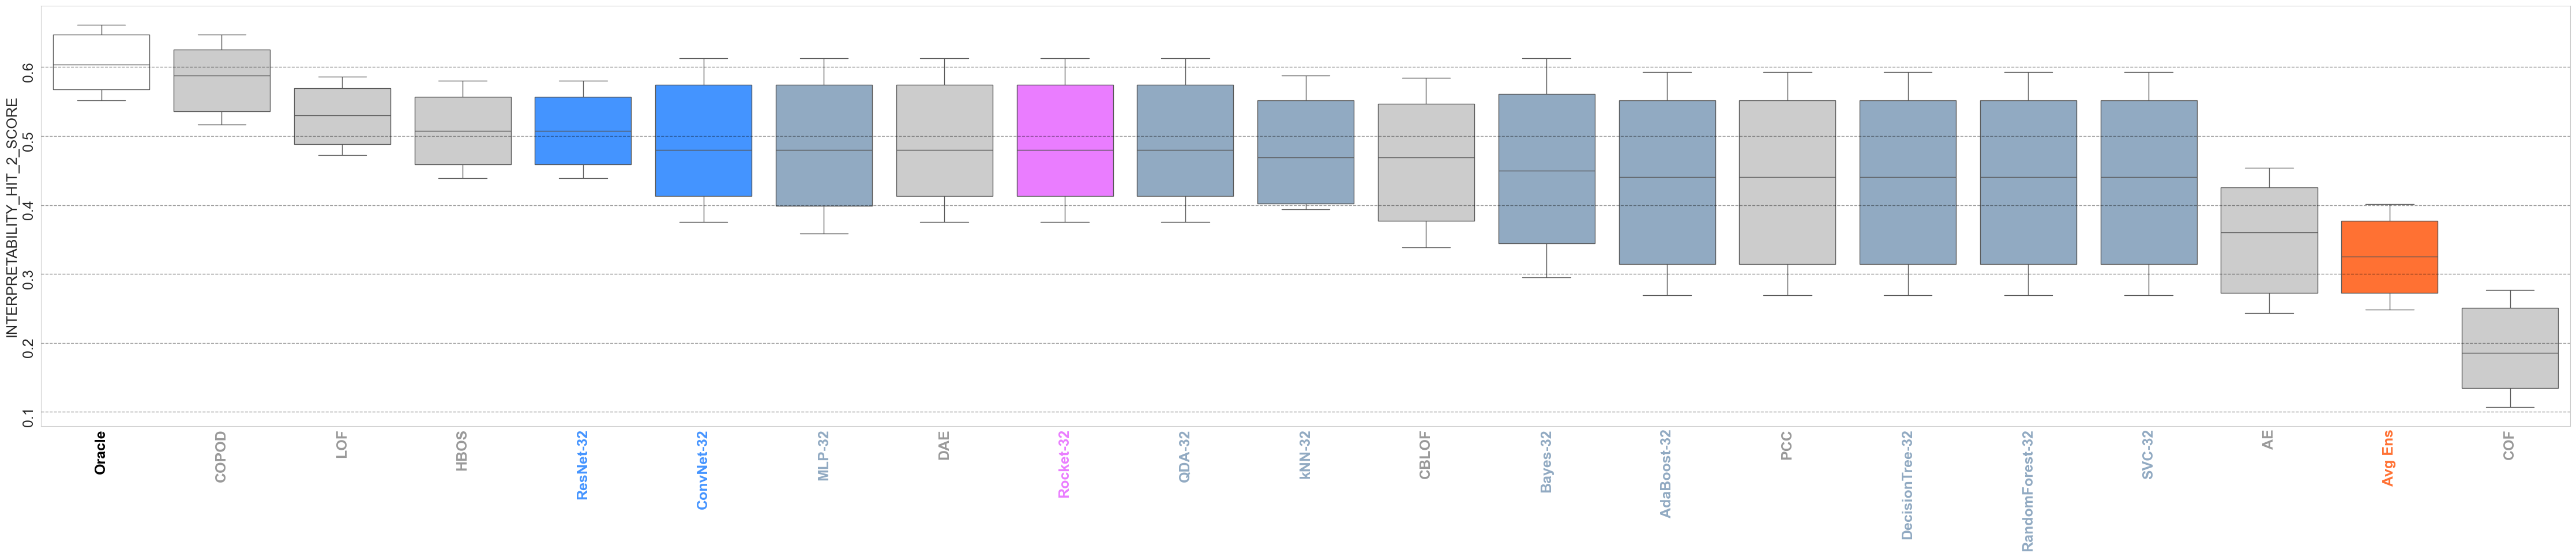

In [28]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(45, 10))
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.4)

order = list(df[all_methods].median().sort_values().index)[::-1]

my_pal = {method: methods_colors["detectors"] for method in old_methods}
for family, color in zip([methods_conv, methods_sit, methods_ts, methods_feature], [methods_colors["conv"], methods_colors["sit"], methods_colors["rocket"],methods_colors["feature_based"]]):
    for length in all_length:
        my_pal_tmp = {method.format(length):color for method in family}
        my_pal = {**my_pal, **my_pal_tmp}
my_pal = {**my_pal,**{"Avg Ens": methods_colors["avg_ens"], 'Oracle': methods_colors["oracle"]}}

# Crete boxplot and stripplot
g = sns.boxplot(data=df[order], palette=my_pal, order=order, saturation=1, whis=0.241289844, showfliers=False) # 1std = 0.241289844, 2std = 0.982579689
g.set_axisbelow(False)

for tick_label in g.axes.get_xticklabels():
    tick_label.set_weight('bold')
    if 'sit_' in tick_label.get_text():
        tick_label.set_color(methods_colors["sit"])
    elif ('convnet_' in tick_label.get_text()) or ('resnet_' in tick_label.get_text()) or ('inception_' in tick_label.get_text()):
        tick_label.set_color(methods_colors["conv"])
    elif 'rocket_' in tick_label.get_text():
        tick_label.set_color(methods_colors["rocket"])
    elif ('Oracle' in tick_label.get_text()):
        tick_label.set_color("black")
    elif ('Avg Ens' in tick_label.get_text()):
        tick_label.set_color(methods_colors["avg_ens"])
    elif '_'not  in tick_label.get_text():
        tick_label.set_color("#999999")
    else:
        tick_label.set_color(methods_colors["feature_based"])

# Change xtick labels to camera-ready names
new_xticks_labels = []
for i, tick_label in enumerate(g.axes.get_xticklabels()):
    method_name = tick_label.get_text()
    if method_name in final_names:
        tick_label.set_text(final_names[method_name])
    else:
        tick_label.set_text(method_name)
    new_xticks_labels.append(tick_label)
g.axes.set_xticklabels(new_xticks_labels)

plt.xticks(rotation=90)
plt.yticks(rotation=90)
plt.ylabel(final_names[measure_name])

plt.tight_layout()
# plt.savefig(figure_path.format('5_overall_results_full_1'))
plt.show()
plt.close()

## A more readable form of the figure
Here we only show the best performing length from each different class of methods

In [131]:
def rreplace(s, old, new, occurrence=1):
    li = s.rsplit(old, occurrence)
    return new.join(li)

/tmp/ipykernel_3218748/601515108.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.axes.set_xticklabels(new_xticks_labels)


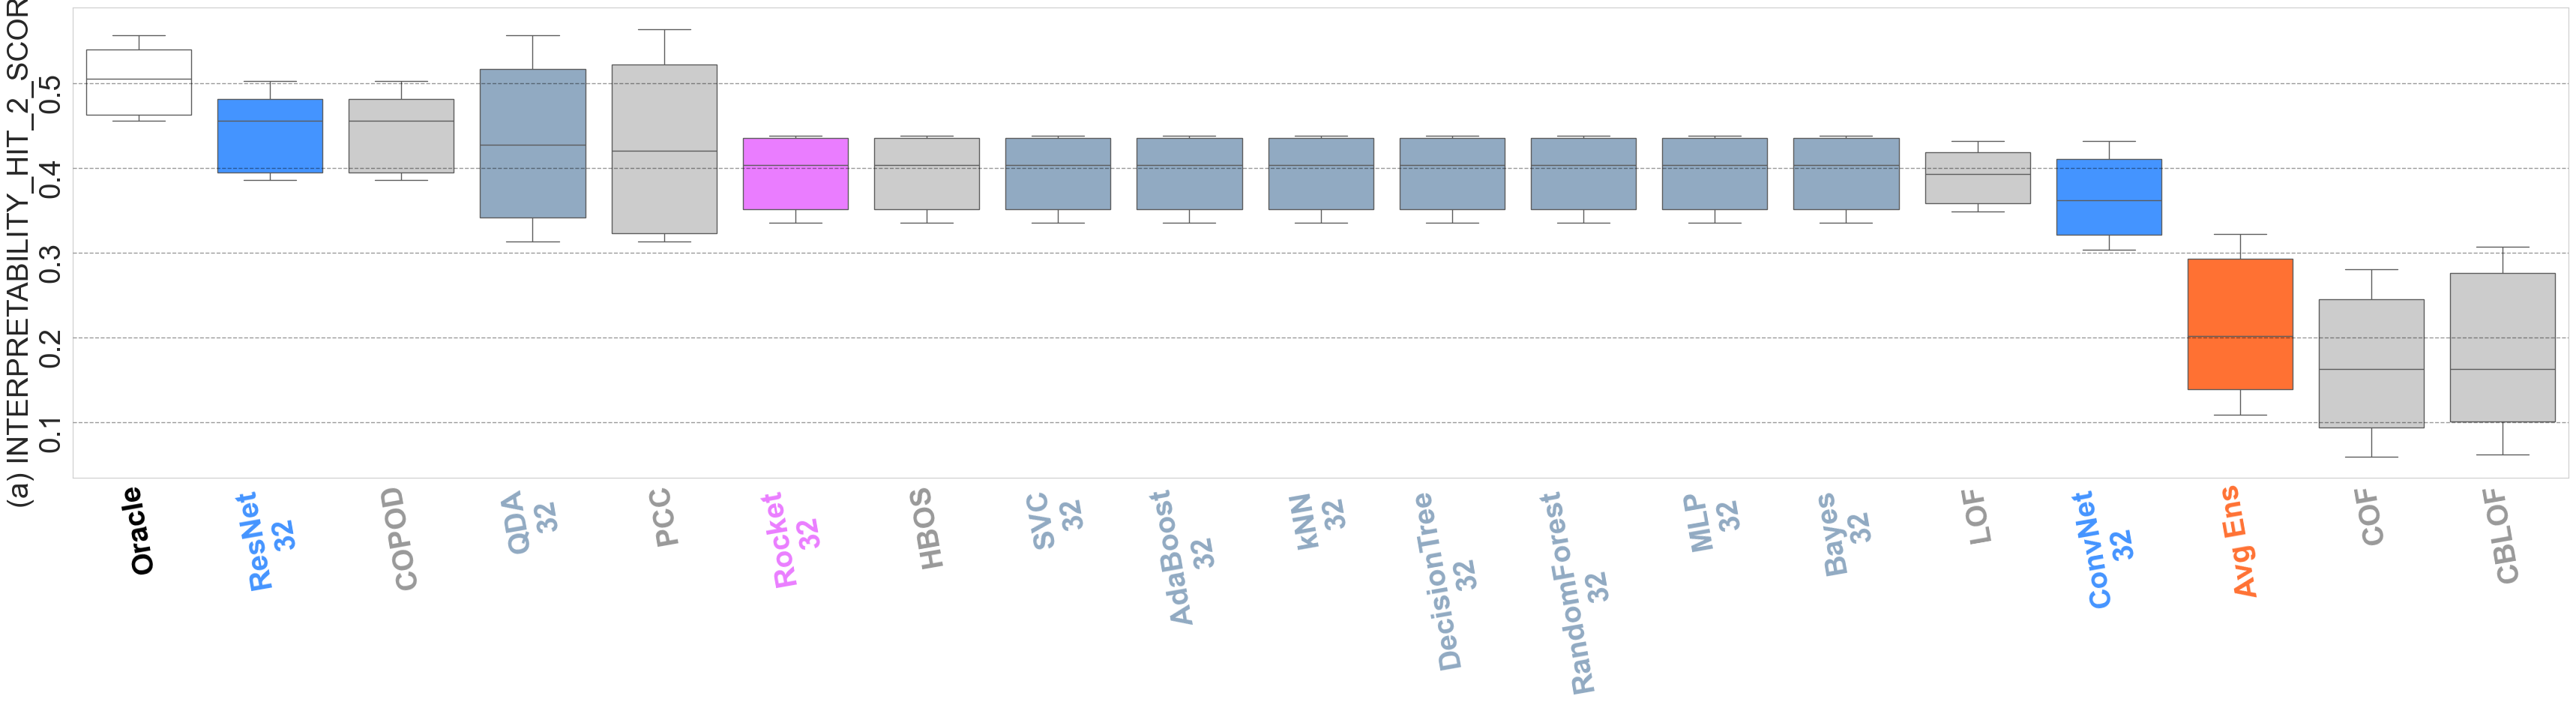

In [132]:
plt.rcParams.update({'font.size': 28})
plt.figure(figsize=(35, 10))
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.4)

order = list(df[all_methods].median().sort_values().index)[::-1]

my_pal = {method: methods_colors["detectors"] for method in old_methods}
for family, color in zip([methods_conv, methods_sit, methods_ts, methods_feature], [methods_colors["conv"], methods_colors["sit"], methods_colors["rocket"],methods_colors["feature_based"]]):
    for length in all_length:
        my_pal_tmp = {method.format(length):color for method in family}
        my_pal = {**my_pal, **my_pal_tmp}
my_pal = {**my_pal,**{"Avg Ens": methods_colors["avg_ens"], 'Oracle': methods_colors["oracle"]}}

# Keep only best from each method class
best_method_class = []
split_order = [x.rsplit('_', 1)[0] for x in order]
for method_class in all_methods_class:
    indexes = split_order.index(method_class)
    best_method_class.append(order[indexes])
new_order = [x for x in order if x in best_method_class]
new_my_pal = {key: my_pal[key] for key in best_method_class}

# Crete boxplot and stripplot
g = sns.boxplot(data=df[new_order], palette=new_my_pal, order=new_order, saturation=1, whis=0.241289844, showfliers=False) # 1std = 0.241289844, 2std = 0.982579689
g.set_axisbelow(False)

for tick_label in g.axes.get_xticklabels():
    tick_label.set_weight('bold')
    if 'sit_' in tick_label.get_text():
        tick_label.set_color(methods_colors["sit"])
    elif ('convnet_' in tick_label.get_text()) or ('resnet_' in tick_label.get_text()) or ('inception_' in tick_label.get_text()):
        tick_label.set_color(methods_colors["conv"])
    elif 'rocket_' in tick_label.get_text():
        tick_label.set_color(methods_colors["rocket"])
    elif ('Oracle' in tick_label.get_text()):
        tick_label.set_color("black")
    elif ('Avg Ens' in tick_label.get_text()):
        tick_label.set_color(methods_colors["avg_ens"])
    elif '_'not  in tick_label.get_text():
        tick_label.set_color("#999999")
    else:
        tick_label.set_color(methods_colors["feature_based"])

# Change xtick labels to camera-ready names
new_xticks_labels = []
for i, tick_label in enumerate(g.axes.get_xticklabels()):
    method_name = tick_label.get_text()
    if method_name in final_names:
        tick_label.set_text(rreplace(final_names[method_name], '-', '\n'))
    else:
        tick_label.set_text(method_name)
    new_xticks_labels.append(tick_label)
g.axes.set_xticklabels(new_xticks_labels)

plt.xticks(rotation=100)
plt.yticks(rotation=90)
plt.ylabel(f"(a) {final_names[measure_name]}")
plt.tight_layout()
# plt.savefig(figure_path.format('5_overall_results_1'))
plt.show()
plt.close()

# !After this point, this notebook will not run without all of the models evaluated!

# Model selected distribution

We then inspect in detail the prediction and the detector chosen by the model selection approaches. In this section, we consider only 𝑟𝑒𝑠𝑛𝑒𝑡-1024, 𝑐𝑜𝑛𝑣𝑛𝑒𝑡-128, 𝑠𝑖𝑡-𝑠𝑡𝑒𝑚-512, 𝑟𝑜𝑐𝑘𝑒𝑡-128, and 𝑘𝑛𝑛-1024. These approaches are the best models (using either AUC-PR or VUS-PR) based on the analysis conducted in Section 5.2.


In [39]:
plt.rcParams.update({'font.size': 16})
my_palette = {'label':'#00154A',
              'resnet_1024_class': "#66A8FF",  # methods_colors["conv"]
              'convnet_128_class': methods_colors["conv_2"],
              'sit_stem_512_class': methods_colors["sit"],
              'rocket_1024_class': methods_colors["rocket"],
              'knn_1024_class': methods_colors["feature_based"]}

plt.figure(figsize=(13, 5))
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.2)
plt.title('(a) Model chosen (all time series)')
columns = ['label','resnet_1024_class','convnet_128_class','sit_stem_512_class','rocket_1024_class','knn_1024_class']
df1 = df[columns].melt(var_name='Model Selection', value_name='Prediction')
sns.countplot(x='Prediction', hue='Model Selection', data=df1, order=old_methods, palette=my_palette, saturation=1)
plt.xticks(rotation=25)
plt.ylabel('Count')
plt.xlabel('')
plt.rc('axes', axisbelow=True)
L = plt.legend()
legend_text = L.get_texts()
new_legend_text = [final_names['label'], final_names['resnet_1024'], final_names['convnet_128'], final_names['sit_stem_512'], final_names['rocket_128'], final_names['knn_1024']]
for txt, new_text in zip(legend_text, new_legend_text):
    txt.set_text(new_text)
plt.tight_layout()
# plt.savefig(figure_path.format('6_classification_distrib_1'))
plt.show()
plt.close()

# Set up subplots
fig = plt.figure(figsize=(13, 8))
fig.suptitle("(b) For time series containing:")

# Set up individual plots
plt.subplot(2,2,1)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.2)
plt.title("(b.1) sequence anomaly")
df1 = df.loc[df['type_an']=='sequence'][columns].melt(var_name='Model Selection', value_name='Prediction')
sns.countplot(x='Prediction', hue='Model Selection', data=df1, order=old_methods, palette=my_palette, saturation=1)
plt.legend([], frameon=False)
plt.xticks([])
plt.ylabel('Count')
plt.xlabel('')
plt.rc('axes', axisbelow=True)

plt.subplot(2, 2, 2)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.2)
plt.title("(b.2) point anomaly")
df1 = df.loc[df['type_an']=='point'][columns].melt(var_name='Model Selection', value_name='Prediction')
sns.countplot(x='Prediction', hue='Model Selection', data=df1, order=old_methods, palette=my_palette, saturation=1)
plt.legend([], frameon=False)
plt.xticks([])
plt.ylabel('Count')
plt.xlabel('')
plt.rc('axes', axisbelow=True)

plt.subplot(2,2,3)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.2)
plt.title("(c.1) Unique anomaly")
df1 = df.loc[df['nb_anomaly']== 1][columns].melt(var_name='Model Selection', value_name='Prediction')
sns.countplot(x='Prediction', hue='Model Selection', data=df1, order=old_methods, palette=my_palette, saturation=1)
plt.legend([], frameon=False)
plt.xticks(rotation=50)
plt.ylabel('Count')
plt.xlabel('')
plt.rc('axes', axisbelow=True)

plt.subplot(2,2,4)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.2)
plt.title("(c.2) multiple anomaly")
df1 = df.loc[df['nb_anomaly'] > 1][columns].melt(var_name='Model Selection', value_name='Prediction')
sns.countplot(x='Prediction', hue='Model Selection', data=df1, order=old_methods, palette=my_palette, saturation=1)
plt.legend([], frameon=False)
plt.xticks(rotation=50)
plt.ylabel('Count')
plt.xlabel('')
plt.rc('axes', axisbelow=True)

plt.tight_layout()
# plt.savefig(figure_path.format('6_classification_distrib_2'))
plt.show()
plt.close()

# Influence of the Datasets and Anomaly Types

In this section, we evaluate the influence of datasets and anomaly characteristics on model selection accuracy. We perform the analysis per group of methods (i.e., average performances for Convolutional, Transformer, rocket, and Feature-based methods).For this experiment, we evaluate the dataset and anomaly characteristics (i.e., the number of time series in the dataset, the average
length of the time series in the dataset, the average number of points
in the dataset, the average number of anomalies, the average anomaly length and the average number of abnormal points). The following figure depicts these characteristics mentioned above (x-axis) versus the average increase of accuracy (accuracy of the model selection method subtracted by accuracy of the best anomaly detection method for
each dataset) for each model selection method using a given window length. For instance, If a point (one model selection method applied to one dataset) is positive (above the black dotted line), thus
the corresponding model is more accurate on the corresponding dataset than the best anomaly detection method selected on this same dataset. The following figure shows a specific example for each window
length. The second plot shows the correlation values (trend of the
different lines in The following figure) versus the window length.


In [33]:
datasets = list(set(df['dataset'].values))

datasets_count = {}
datasets_length = {}
anom_length = {}
anom_count = {}
anom_ratio = {}

for dataset in datasets:
    # Calculate count of occurrences of each dataset
    datasets_count[dataset] = len(df[df['dataset'] == dataset])
    
    # Calculate the mean length of data for each dataset
    datasets_length[dataset] = df[df['dataset'] == dataset]['data_len'].mean()
    
    # Calculate the mean length of anomalies for each dataset
    anom_length[dataset] = df[df['dataset'] == dataset]['average_anom_length'].mean()
    
    # Calculate the mean count of anomalies for each dataset
    anom_count[dataset] = df[df['dataset'] == dataset]['nb_anomaly'].mean()
    
    # Calculate the mean ratio of anomalies for each dataset
    anom_ratio[dataset] = df[df['dataset'] == dataset]['ratio'].mean()

In [67]:
def regplot(x, y, color, pos, right=True):
    b, m = polyfit(x, y, 1)
    correlation = np.corrcoef(x, y)[0,1]
    plt.plot(np.sort(x) , b + m * np.sort(x), color=color)
    if right:
        plt.text(.65, .08 + 0.08*pos, 'r={:.3f}'.format(correlation), ha='left', va='top', transform=plt.gca().transAxes, color=color)
    else:
        plt.text(.01, .08 + 0.08*pos, 'r={:.3f}'.format(correlation), ha='left', va='top', transform=plt.gca().transAxes, color=color)
    return correlation
    
def corr_plot_dataset(methods_ens_length, length, datasets_count=datasets_count, datasets_length=datasets_length, type_a='time series'):
    # Set font size and figure size for the plot
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(12,3))
    
    # Initialize dictionaries to store mean increase for different methods
    mean_increase_dataset_conv, mean_increase_dataset_sit, mean_increase_dataset_feature, mean_increase_dataset_ts = {}, {}, {}, {}
    
    # Iterate through dataset
    for i, dataset in enumerate(datasets):
        # Compute mean increase for ensemble methods and subtract old methods
        mean_ens = df.loc[df['dataset'] == dataset][methods_ens_length].mean().to_dict()
        old = df.loc[df['dataset'] == dataset][old_methods].mean().to_dict()
        mean_ens = {key: val - old[max(old, key=old.get)] for key, val in mean_ens.items()}
            
        # Filter mean increase data for different types of methods
        mean_ens_sit =  {key: val for key, val in mean_ens.items() if key in [method.format(length) for method in methods_sit]}
        mean_ens_conv =  {key: val for key, val in mean_ens.items() if key in [method.format(length) for method in methods_conv]}
        mean_ens_feature =  {key: val for key, val in mean_ens.items() if key in [method.format(length) for method in methods_feature]}
        mean_ens_ts =  {key: val for key, val in mean_ens.items() if key in [method.format(length) for method in methods_ts]}
        
        # Calculate mean increase for each type of method and store in dictionaries
        mean_increase_dataset_conv[dataset] = np.array(list(mean_ens_conv.values())).mean()
        mean_increase_dataset_sit[dataset] = np.array(list(mean_ens_sit.values())).mean()
        mean_increase_dataset_feature[dataset] = np.array(list(mean_ens_feature.values())).mean()
        mean_increase_dataset_ts[dataset] = np.array(list(mean_ens_ts.values())).mean()
    
    def plot_subplot(datasets, is_right):
        # Create subplots and scatter plots
        plt.axhline(0, color='black', linestyle='--')
        plt.ylabel('Avg increase')
        plt.scatter(datasets, np.array(list(mean_increase_dataset_conv.values())), c=methods_colors['conv'], s=50)
        correlation_conv = regplot(x=datasets, y=np.array(list(mean_increase_dataset_conv.values())), color=methods_colors['conv'], pos=0, right=is_right) 
        plt.scatter(datasets, np.array(list(mean_increase_dataset_sit.values())), c=methods_colors['sit'], s=50, marker='s')
        correlation_sit = regplot(x=datasets, y=np.array(list(mean_increase_dataset_sit.values())), color=methods_colors['sit'], pos=1, right=is_right)
        plt.scatter(datasets, np.array(list(mean_increase_dataset_feature.values())), c=methods_colors['feature_based'], s=50, marker='^')
        correlation_classical = regplot(x=datasets, y=np.array(list(mean_increase_dataset_feature.values())), color=methods_colors['feature_based'], pos=2, right=is_right)
        plt.scatter(datasets, np.array(list(mean_increase_dataset_ts.values())), c=methods_colors['rocket'], s=50, marker='x')
        correlation_ts = regplot(x=datasets, y=np.array(list(mean_increase_dataset_ts.values())), color=methods_colors['rocket'], pos=3, right=is_right)
        datasets_corr = [correlation_conv, correlation_sit, correlation_classical, correlation_ts]
        return datasets_corr
    
    # Create subplots for different aspects of the data
    plt.subplot(1,3,1)
    datasets_count_corr = plot_subplot(np.array(list(datasets_count.values())), is_right=True)
    plt.xlabel('Number of {}'.format(type_a))
    
    plt.subplot(1,3,2)
    plt.title("Window length: {}".format(length))
    datasets_length_corr = plot_subplot(np.array(list(datasets_length.values())), is_right=False)
    plt.xlabel('Avg {} length'.format(type_a))
    plt.xscale('log')
    
    plt.subplot(1,3,3)
    datasets_point_corr = plot_subplot(np.multiply(np.array(list(datasets_length.values())), np.array(list(datasets_count.values()))), is_right=True)
    plt.xlabel('Avg # of points')
    plt.xscale('log')
        
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return datasets_count_corr, datasets_length_corr, datasets_point_corr

## Influence of Time series caracteristics

In [68]:
datasets_count_corr_list, datasets_length_corr_list, datasets_point_corr_list = [], [], []
for length in all_length:
    all_methods_length = [meth.format(length) for meth in methods_conv + methods_sit + methods_ts + methods_feature]
    all_methods_length = [x for x in all_methods_length if x in df]
    datasets_count_corr, datasets_length_corr, datasets_point_corr = corr_plot_dataset(all_methods_length, length, datasets_count=datasets_count, datasets_length=datasets_length, type_a='time series')
    datasets_count_corr_list.append(datasets_count_corr)
    datasets_length_corr_list.append(datasets_length_corr)
    datasets_point_corr_list.append(datasets_point_corr)

datasets_point_corr_list = np.array(datasets_point_corr_list)
datasets_count_corr_list = np.array(datasets_count_corr_list)
datasets_length_corr_list = np.array(datasets_length_corr_list)

In [69]:
plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 16})
plot_titles = ['Nb of time series', 'Avg time series length', 'Avg # of points']

for count, datasets_corr_list in enumerate([datasets_count_corr_list, datasets_length_corr_list, datasets_point_corr_list]):
    plt.subplot(1, 3, 1 + count)
    plt.title(plot_titles[count])
    for i, color, mark_s in zip(range(4), [methods_colors["conv"], methods_colors["sit"], methods_colors["rocket"], methods_colors["feature_based"]], ['o', 's', '^', 'x']):
        plt.plot(all_length, datasets_corr_list[:, i], color=color)
        plt.scatter(all_length, datasets_corr_list[:, i], c=color, s=50, marker=mark_s)
    plt.ylabel('Correlation r')
    plt.xlabel('Window length')
    plt.xscale('log')
    plt.ylim(-1, 1)
    plt.axhline(0, linestyle='--', color='black')

plt.tight_layout()
# plt.savefig(figure_path.format("9_infl_charac_1"))
plt.show()
plt.close()

## Influence of Anomaly caracteristics

In [71]:
datasets_count_corr_list, datasets_length_corr_list, datasets_point_corr_list = [], [], []
for length in all_length:
    all_methods_length = [meth.format(length) for meth in methods_conv + methods_sit + methods_ts + methods_feature]
    all_methods_length = [x for x in all_methods_length if x in all_methods]
    datasets_count_corr, datasets_length_corr, datasets_point_corr = corr_plot_dataset(all_methods_length, length, datasets_count=anom_count, datasets_length=anom_length, type_a='anomaly')
    datasets_count_corr_list.append(datasets_count_corr)
    datasets_length_corr_list.append(datasets_length_corr)
    datasets_point_corr_list.append(datasets_point_corr)

datasets_point_corr_list = np.array(datasets_point_corr_list)
datasets_count_corr_list = np.array(datasets_count_corr_list)
datasets_length_corr_list = np.array(datasets_length_corr_list)

In [72]:
plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 16})
plot_titles = ['Nb of Anomalies', 'Avg anomaly length', 'Avg # of points']

for count, datasets_corr_list in enumerate([datasets_count_corr_list, datasets_length_corr_list, datasets_point_corr_list]):
    plt.subplot(1, 3, 1 + count)
    plt.title(plot_titles[count])
    for i, color, mark_s in zip(range(4), [methods_colors["conv"], methods_colors["sit"], methods_colors["rocket"], methods_colors["feature_based"]],['o', 's', '^', 'x']):
        plt.plot(all_length, datasets_corr_list[:,i], color=color)
        plt.scatter(all_length, datasets_corr_list[:,i], c=color, s=50, marker=mark_s)
    plt.ylabel('Correlation r')
    plt.xlabel('Window length')
    plt.xscale('log')
    plt.ylim(-1,1)
    plt.axhline(0, linestyle='--', color='black')

plt.tight_layout()
# plt.savefig(figure_path.format("9_infl_charac_2"))
plt.show()
plt.close()

# Influence of the window length

In this section, we analyze the influence of the window length on
anomaly detection and classification accuracy. We perform
the analysis per group of methods (i.e., average performances for
Convolutional, Transformer, rocket, and Feature-based methods).

In [74]:
def plot_mean_length(class_acc=False):
    plt.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(5.5, 3.25))
    mean_sit, mean_conv, mean_feature, mean_ts = [], [], [], []
    
    for method in methods_conv + methods_feature + methods_sit + methods_ts:
        to_plot = [x for x in [method.format(length) for length in all_length] if x in all_methods]
        if class_acc:
            ts_length = []
            for method_name in to_plot:
                ts_length.append(float(len(df.loc[df[method_name + '_class'] == df['label']])) / float(len(df)))
        else:
            ts_length = df[to_plot].mean().values
        
        if method in methods_sit:
            mean_sit.append(ts_length)
        elif method in methods_feature:
            mean_feature.append(ts_length)
        elif method in methods_conv:
            mean_conv.append(ts_length)
        elif method in methods_ts:
            mean_ts.append(ts_length)
    
    plt.plot(all_length, np.mean(mean_conv, 0), marker='o', color=methods_colors["conv"], label=final_names["convnet"])
    plt.plot(all_length, np.mean(mean_sit, 0), marker='s', color=methods_colors["sit"], label=final_names["sit"])
    plt.plot(all_length, np.mean(mean_feature, 0), marker='^', color=methods_colors["feature_based"], label=final_names["feature_based"])
    plt.plot(all_length, np.mean(mean_ts, 0), marker='x', color=methods_colors["rocket"], label=final_names["rocket"])

    plt.xscale('log')
#     plt.xticks(np.arange(len(all_length)), all_length)
#     plt.xticks(all_length)
    plt.xlim(16, 1024)
#     plt.xlabel('window length (log scale)')
    
    if class_acc:
        fig_name = '8_window_length_1'
        plt.ylabel('Classification Acc.')
        plt.title('(a) Accuracy vs window length')
#         fig.text(0.29, 0.95, "(a)", ha="center", va="bottom", size="large", color="black")
#         fig.text(0.41, 0.95, "Accuracy", ha="center", va="bottom", size="large", color="red")
#         fig.text(0.66, 0.95, " vs window length", ha="center", va="bottom", size="large", color="black")
    else:
        fig_name = '8_window_length_2'
        plt.axhline(df['Oracle'].mean(), c="#000000", linestyle='dotted', label=final_names["Oracle"])
        plt.axhline(df['Avg Ens'].mean(), c=methods_colors["avg_ens"], linestyle='dashed', label=final_names["Avg Ens"])
        plt.axhline(df['NORMA'].mean(), c=methods_colors["best_ad_train"], linestyle='dashdot', label="Best AD")
#         plt.text(18, df['Oracle'].mean() - 0.02, "Oracle", fontsize=12)
        plt.ylabel(final_names[measure_name])
#         plt.title('Accuracy of methods family vs length')

    plt.axhline(df['Oracle'].mean(), c="#000000", linestyle='dotted', label=final_names["Oracle"])
    plt.axhline(df['Avg Ens'].mean(), c=methods_colors["avg_ens"], linestyle='dashed', label=final_names["Avg Ens"])
    plt.axhline(df['NORMA'].mean(), c=methods_colors["best_ad_train"], linestyle='dashdot', label="Best AD")
    
#     plt.legend()
#     plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=5)
    plt.tight_layout()
#     plt.savefig(figure_path.format(fig_name))
    plt.show()
    plt.close()

plot_mean_length(class_acc=True)
plot_mean_length()